In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)
num_samples = 5000
L = 1.0
alpha = 0.01
N = 1 
x_train = np.random.uniform(0, L, (num_samples, 1))
t_train = np.random.uniform(0, 1, (num_samples, 1))

def exact_solution(x, t, L=1.0, alpha=0.01, N=1):
    u = np.zeros_like(x)
    for n in range(1, N+1):
        Bn = 1
        u += Bn * np.sin(n * np.pi * x / L) * np.exp(-alpha * (n * np.pi / L)**2 * t)
    return u

u_exact = exact_solution(x_train, t_train, L=L, alpha=alpha, N=N)
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_train_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
u_exact_tf = tf.convert_to_tensor(u_exact, dtype=tf.float32)
input_train = tf.concat([x_train_tf, t_train_tf], axis=1)


In [4]:
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(100, activation='tanh') for _ in range(4)]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)
def physics_loss(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        u_pred = model(tf.concat([x, t], axis=1))
        u_x = tape.gradient(u_pred, x)
        u_xx = tape.gradient(u_x, x)
        u_t = tape.gradient(u_pred, t)
    
    alpha = 0.01 
    pde_residual = u_t - alpha * u_xx
    return tf.reduce_mean(tf.square(pde_residual))


In [5]:
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
num_epochs = 5000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss_physics = physics_loss(model, x_train_tf, t_train_tf)
        loss_data = tf.reduce_mean(tf.square(model(input_train) - u_exact_tf))
        total_loss = loss_physics + loss_data
    
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()}, Physics Loss: {loss_physics.numpy()}, Data Loss: {loss_data.numpy()}")


Epoch 0, Total Loss: 0.45427557826042175, Physics Loss: 0.0009017562842927873, Data Loss: 0.45337381958961487
Epoch 500, Total Loss: 0.02706102468073368, Physics Loss: 0.001232338952831924, Data Loss: 0.025828685611486435
Epoch 1000, Total Loss: 0.001574723981320858, Physics Loss: 0.0006715950439684093, Data Loss: 0.0009031289373524487
Epoch 1500, Total Loss: 0.0008888585725799203, Physics Loss: 0.00041313160909339786, Data Loss: 0.0004757269925903529
Epoch 2000, Total Loss: 0.0005876487120985985, Physics Loss: 0.0002520002017263323, Data Loss: 0.00033564853947609663
Epoch 2500, Total Loss: 0.00037924537900835276, Physics Loss: 0.00014470137830357999, Data Loss: 0.00023454398615285754
Epoch 3000, Total Loss: 0.00023087227600626647, Physics Loss: 7.322448800550774e-05, Data Loss: 0.00015764779527671635
Epoch 3500, Total Loss: 0.00014011457096785307, Physics Loss: 3.769386967178434e-05, Data Loss: 0.00010242070129606873
Epoch 4000, Total Loss: 9.169161057798192e-05, Physics Loss: 2.35982

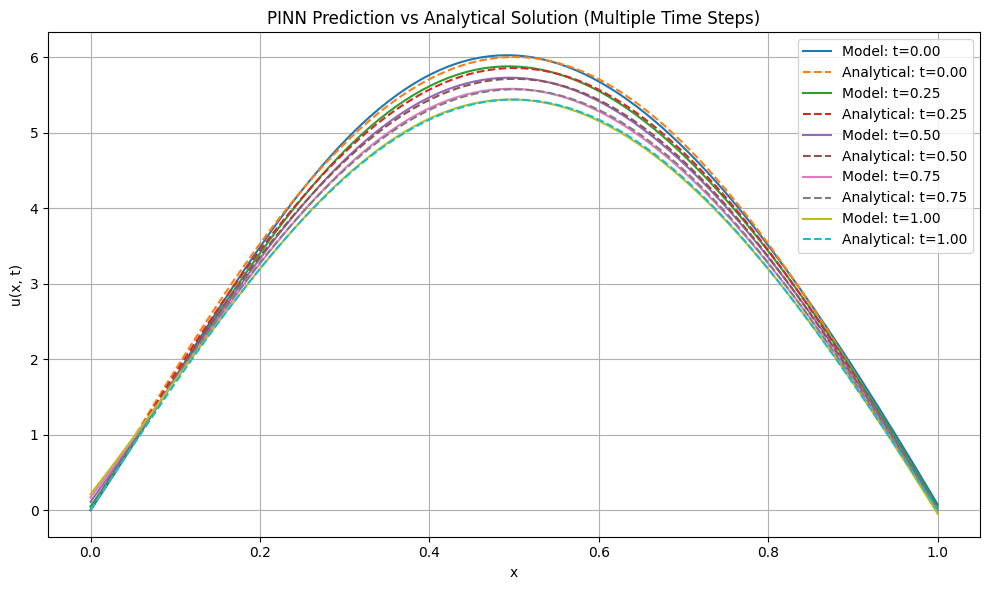

In [6]:
alpha = 0.01
x_test = np.linspace(0, 1, 200).reshape(-1, 1)
t_test = np.linspace(0, 1, 5) 
x_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
def f_a(x):
    return 6 * np.sin(np.pi * x)
def analytical_solution(x, t):
    return f_a(x) * np.exp(-alpha * (np.pi**2) * t)
plt.style.use('default')
plt.figure(figsize=(10, 6))

for t in t_test:
    t_tensor = tf.convert_to_tensor(np.full_like(x_test, t), dtype=tf.float32)
    input_test = tf.concat([x_tensor, t_tensor], axis=1)
    u_pred = model(input_test).numpy()
    u_analytical = analytical_solution(x_test, t)

    plt.plot(x_test,6*u_pred, label=f"Model: t={t:.2f}")
    plt.plot(x_test, u_analytical, '--', label=f"Analytical: t={t:.2f}")

plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.title("PINN Prediction vs Analytical Solution (Multiple Time Steps)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
model.save("./models/pinn_model_recreated.keras")



In [8]:
from sklearn.metrics import mean_squared_error

alpha = 0.01
x_test = np.linspace(0, 1, 200).reshape(-1, 1)
t_test = np.linspace(0, 1, 5)
x_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)

def f_a(x):
    return 6 * np.sin(np.pi * x)

def analytical_solution(x, t):
    return f_a(x) * np.exp(-alpha * (np.pi**2) * t)

for t in t_test:
    t_tensor = tf.convert_to_tensor(np.full_like(x_test, t), dtype=tf.float32)
    input_test = tf.concat([x_tensor, t_tensor], axis=1)
    u_pred = model(input_test).numpy()
    u_analytical = analytical_solution(x_test, t)

    mse = mean_squared_error(u_analytical, 6 * u_pred)
    print(f"MSE at t={t:.2f}: {mse:.6f}")


MSE at t=0.00: 0.002516
MSE at t=0.25: 0.001308
MSE at t=0.50: 0.000713
MSE at t=0.75: 0.000989
MSE at t=1.00: 0.001670
